In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# load general packages
import numpy as np

# load modules related to this exercise
from model_zucher import zurcher
from Solve_NFXP import solve_NFXP
import estimate_NFXP as estimate
import warnings
# Turn off warnings: We turn of warnings as a result of overflow. This occurs as the optimizer will sometimes guess on non-feasible transition probabilities. 
warnings.filterwarnings("ignore", category=RuntimeWarning)


C:\Users\sofie\AppData\Local\Temp\ipykernel_11256\238151446.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


#  Exercise 3: Demand function

#### 1. Find the equilibrium distirbution of mileage

In [13]:
# Setup
do_settings = {
    'n': 90
}

model = zurcher(**do_settings)
solver = solve_NFXP()

#Read the data
data = model.read_busdata(bustypes=[1,2,3,4])
samplesize = data.shape[0]
uncond_R_P = sum(data.d)/samplesize

# Estimate
nfxp_model, optim_res, pnames, theta_hat, Avar, converged=estimate.estimate(model, solver,data)

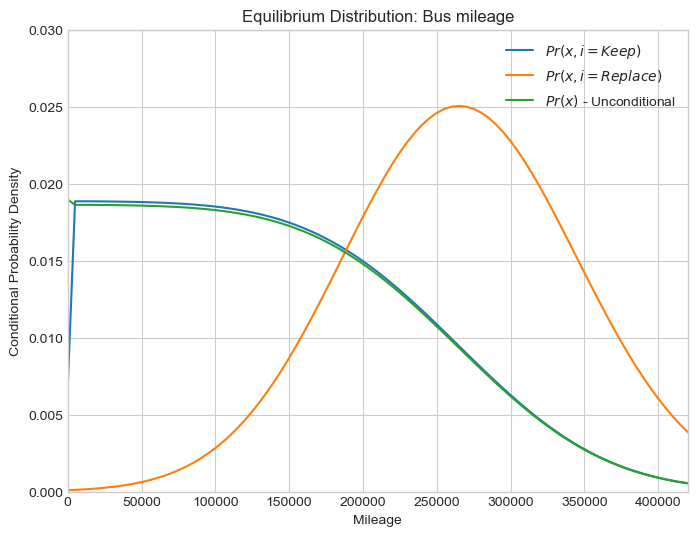

In [14]:
# Update the values with the estimated parameters
do_settings = {
    'n': 90,
    'RC': theta_hat[0],
    'c': theta_hat[1],
    'p': np.array(theta_hat[2:])
}
ev0 = np.zeros((model.n))
model_est = zurcher(**do_settings)
ev,pk = solver.poly(model_est.bellman,ev0, beta = model_est.beta, output=2)

# Find the probability functions
pp, pp_K, pp_R = model_est.eqb(pk)

fig = plt.figure(figsize=(8,6)) 
ax = fig.add_subplot(1,1,1)

ax.plot(model_est.grid*(model_est.max*1000)/model_est.n,pp_K/sum(pp_K))
ax.plot(model_est.grid*(model_est.max*1000)/model_est.n,pp_R/sum(pp_R))
ax.plot(model_est.grid*(model_est.max*1000)/model_est.n,pp/sum(pp))


ax.set_title(f'Equilibrium Distribution: Bus mileage')
ax.set_xlabel("Mileage")
ax.set_ylabel("Conditional Probability Density")
ax.set_xlim(0, 420000)
ax.set_ylim(0, 0.03)

plt.legend((f'$Pr(x, i=Keep)$',f'$Pr(x, i=Replace)$', f'$Pr(x)$ - Unconditional'))

plt.show()

#### 2. Find the scale of the cost function
a) How does the scale of the cost function relate to the estimate of RC and c? Hint: We implicitly assume that the standard deviation of the extreme value type 1 distributed shocks are equal to 1. 

b) What is the actual average replacement cost? Hint: Use the stuctural estimates and tabel III in  Rust (1987), "Optimal Replacement of GMC Bus Engines: An Emperical Model of Harold Zurcher (Table 3, Bus group 1,2,3,4)

c) How can we use this to estimate the scale of the cost function? Calculate the scale.

#### 3. Find the implied Demand function

In [ ]:
# Expected Demand, as a function of Replacement cost
import copy
mp0 = copy.copy(model_est.RC)
NRC = 59
RCgrid = np.linspace(1,30,NRC)
ev0 = np.zeros((model.n))

Demand = np.empty(NRC)

for i,val in enumerate(RCgrid):
    do_settings = {
    'n': 90,
    'RC': val,
    'c': theta_hat[1],
    'p': np.array(theta_hat[2:])
    }

    model = zurcher(**do_settings)
    _,pk = solver.poly(model.bellman, ev0, beta= model.beta, output=2)
    
    # Find the probability functions
    pp, pp_K, pp_R = model.eqb(pk)
    
    Demand[i] = 12*sum(pp_R)

fig = plt.figure(figsize=(8,6)) 
ax2 = fig.add_subplot(1,1,1)
ax2.plot(RCgrid*scale,Demand)
ax2.set_title(f'Expected Replacement Demand Function')
ax2.set_xlabel("Replacement cost, RC")
ax2.set_ylabel("Expected Annual Engine Replacement")
ax2.set_xlim(0,12000)
ax2.set_ylim(0,1)

plt.show()

#### 4. Try estimate the demand function for different values of $\beta$. Does the change in the demand function makes intuitively sense?

a) Where do the demand curves cross?

In [ ]:
beta_vec = np.array([0.001, 0.9999])

Demand_beta = np.empty((NRC,2))
scale_beta = np.empty(2)


for j,beta in enumerate(beta_vec):
    # Setup
    do_settings = {
        'n': 90,
        'beta': beta
    }

    model = zurcher(**do_settings)
    solver = solve_NFXP()
    #Fill in

In [ ]:
fig = plt.figure(figsize=(8,6)) 
ax2 = fig.add_subplot(1,1,1)
ax2.plot(RCgrid*scale_beta[0],Demand_beta[:,0])
ax2.plot(RCgrid*scale_beta[1],Demand_beta[:,1])
plt.legend((f'$\u03B2=0$',f'$\u03B2= 0.9999$'))
ax2.set_title(f'Expected Replacement Demand Function')
ax2.set_xlabel("Replacement cost, RC")
ax2.set_ylabel("Expected Annual Engine Replacement")
ax2.set_xlim(0,12000)
ax2.set_ylim(0,1)

plt.show()

#### 5. What are the advantage and disadvantage of using a structual model to estimate the demand?